In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [4]:
## now importing data from PLANT VILLAGE WITH DEFINITE SIZE OF PICTURE AND IN BATCH

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
    )

Found 22114 files belonging to 15 classes.


In [6]:
class_names= dataset.class_names
class_names #to print number of classes

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy']

In [7]:
len(dataset)
#total images  692 * 32 (i.e batch size)

692

In [22]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    #print(image_batch[0].numpy())

(32, 256, 256, 3)
[ 2 14 13  4 12 14  9 13  3 12 13 12  1 13 13  9 14 14 13  4 13  3  3  3
  8 10 13 11 12  7 13 13]


In [9]:
# here 3 is channels as rgb

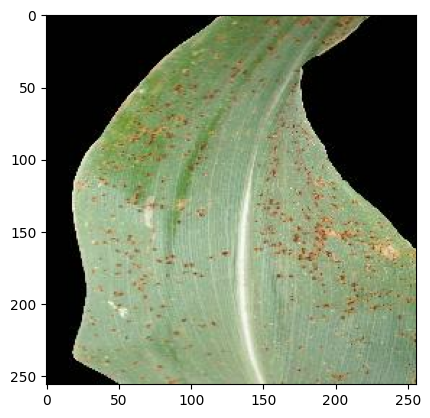

In [24]:
for image_batch,label_batch in dataset.take(1):
    #plt.imshow(image_batch[0])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

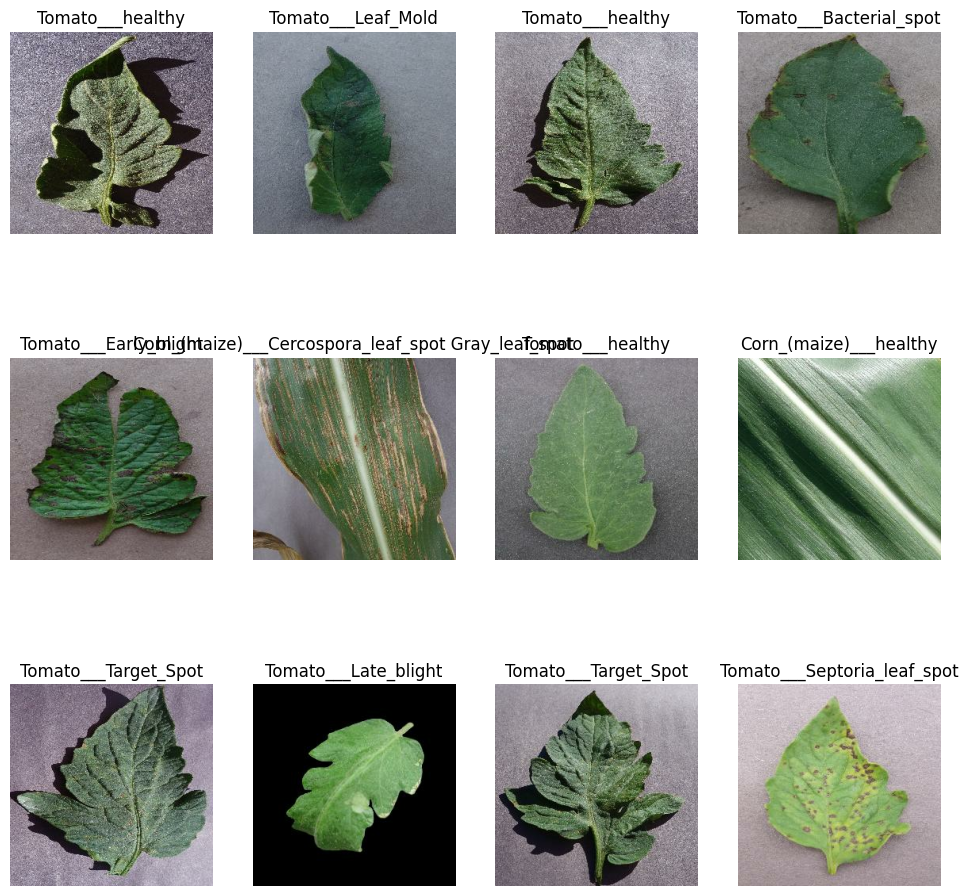

In [25]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
   for i in range(12): 
     ax = plt.subplot(3,4,i+1) # shows pictures in 3 row and 4 column  
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off") 

In [26]:
# from total data 
 #       80% data  => training
  #      10% data  => validation
   #     10% data  => test  for accuracy of our model before deploying


In [27]:
len(dataset)

692

In [28]:
#FOR SPLITTING DATASET WE USE SKLEARN

In [29]:
train_size= 0.8
len(dataset)*train_size

553.6

In [30]:
train_ds = dataset.take(553)
len(train_ds)

553

In [31]:
test_ds = dataset.skip(553)
len(test_ds)

139

In [32]:
val_size=0.1
len(dataset)*val_size

69.2

In [33]:
val_ds=test_ds.take(69)
len(val_ds)

69

In [34]:
test_ds = test_ds.skip(69)
len(test_ds)

70

In [35]:
def get_dataset_partitions_tf(ds,train_split= 0.8,val_split= 0.1,test_split=0.1,shuffle=True,shuffle_size= 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #seed is for predictability
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [36]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

553

In [38]:
len(val_ds)

69

In [39]:
len(test_ds)

70

In [40]:
train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
# keep the image in memory so improves the performance of pipeline
#if GPU is busy in training, prefetch will load next set of batch from disk which improves the performance 

#while GPU training batch 1, CPU will load other one

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# DATA AUGMENTATION

In [41]:
##first thing in IMAGE PROCESSING IS SCALLING the pixel values of pictures-- 0-255 scale(RGB)scale s

In [42]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [43]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# MODEL BUILDING

### Below one is the neural network architecture

In [44]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 15
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'), 
    layers.Dense(n_classes,activation='softmax'), #softmax function normalize the probability of classes
])
model.build(input_shape= input_shape)

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [46]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
) 

In [47]:
EPOCHS= 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30


553/553 [==============================] - 1409s 2s/step - loss: 1.6211 - accuracy: 0.4604 - val_loss: 1.1651 - val_accuracy: 0.6037
Epoch 2/30
553/553 [==============================] - 2188s 2s/step - loss: 0.8377 - accuracy: 0.7049 - val_loss: 0.7657 - val_accuracy: 0.7287
Epoch 3/30
553/553 [==============================] - 2161s 3s/step - loss: 0.6177 - accuracy: 0.7823 - val_loss: 0.8028 - val_accuracy: 0.7233
Epoch 4/30
553/553 [==============================] - 2207s 3s/step - loss: 0.5195 - accuracy: 0.8162 - val_loss: 0.6210 - val_accuracy: 0.7799
Epoch 5/30
553/553 [==============================] - 2093s 2s/step - loss: 0.4708 - accuracy: 0.8371 - val_loss: 0.4242 - val_accuracy: 0.8433
Epoch 6/30
553/553 [==============================] - 1957s 2s/step - loss: 0.4168 - accuracy: 0.8528 - val_loss: 0.4495 - val_accuracy: 0.8469
Epoch 7/30
553/553 [==============================] - 1481s 2s/step - loss: 0.3711 - accuracy: 0.8711 - val_loss: 0.3647 - val_accurac

In [48]:
scores = model.evaluate(test_ds)

70/70 [==============================] - 143s 359ms/step - loss: 0.1501 - accuracy: 0.9511


In [49]:
scores

[0.15011101961135864, 0.9511312246322632]

In [50]:
history

In [51]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 553}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


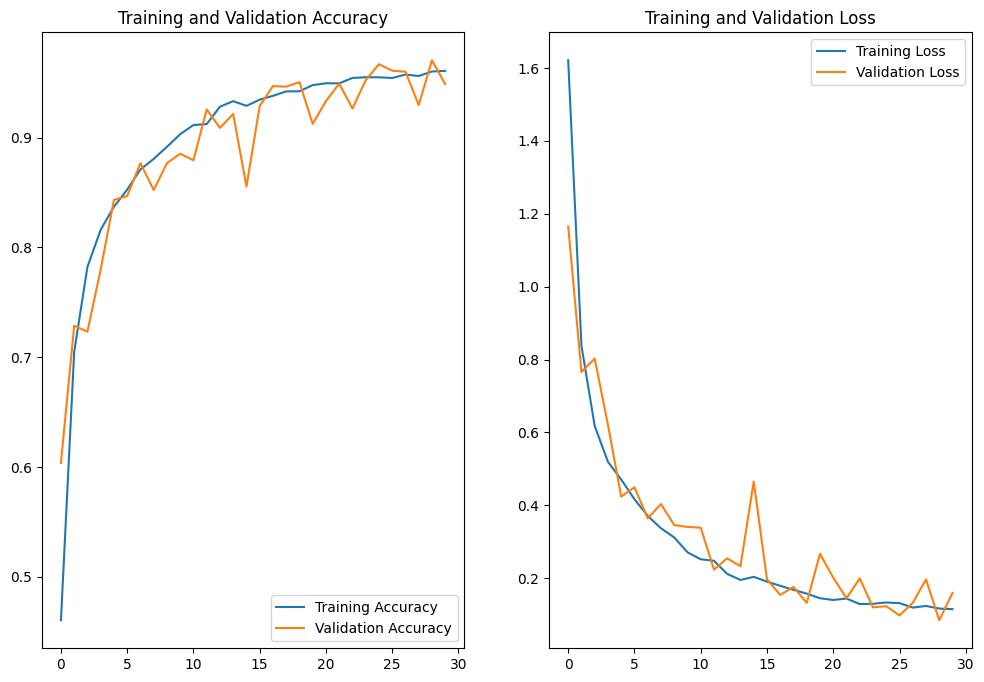

In [58]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
import numpy as np

First Image to Predict
First image's Actual Label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
1/1 [==============================] - 17s 17s/step
Predicted lable: Tomato___Tomato_Yellow_Leaf_Curl_Virus


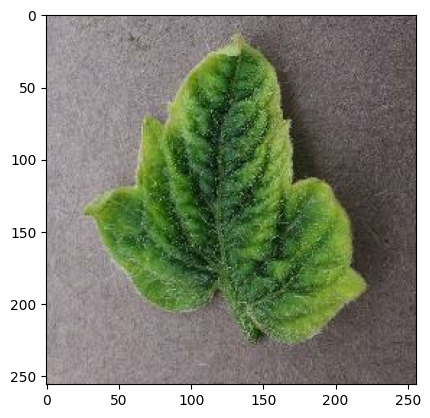

In [64]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("First Image to Predict")
    plt.imshow(first_image)
    print("First image's Actual Label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted lable:",class_names[np.argmax(batch_prediction[0])]) #argmax since it takes 3 arguments and which is maximum is considered here

In [65]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2) # accuracy of prediction in percent
    return predicted_class,confidence

1/1 [==============================] - 0s 158ms/step


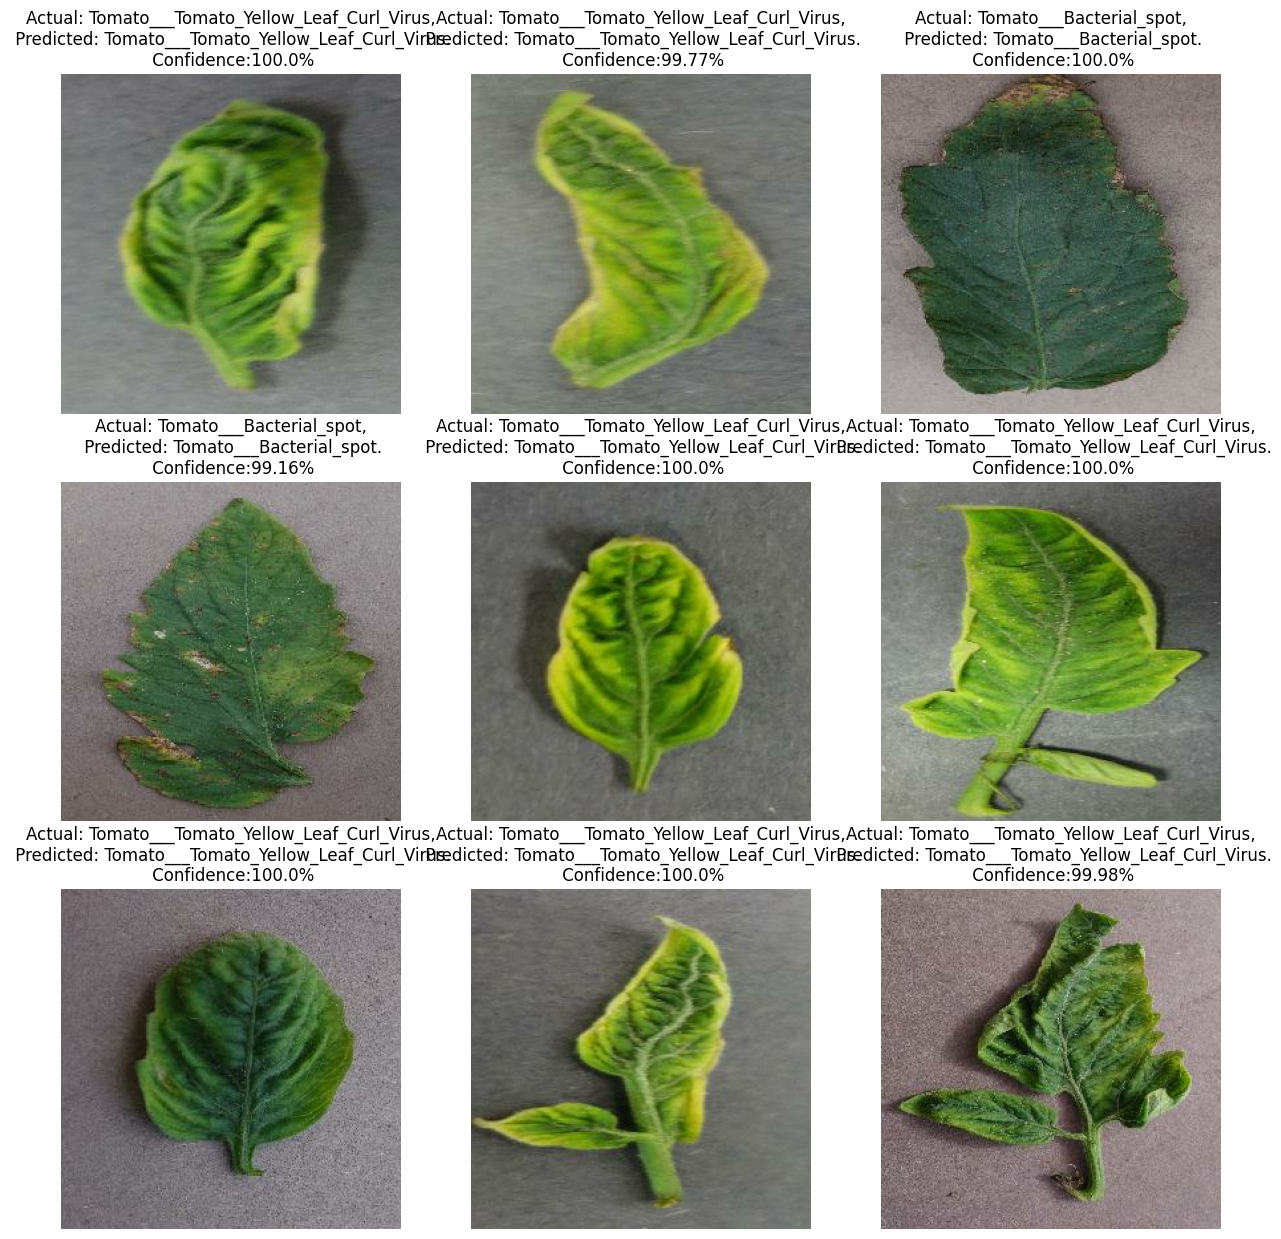

In [68]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")

In [69]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
##You can change different architectur